<a href="https://colab.research.google.com/github/gc625/DLCV/blob/main/ws2b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torchvision import transforms
from PIL import Image
import PIL

# Helper Function
Some helper functions convenience:

`show_image(sample_from_dataset)`: displays an image from the dataset given index `idx`

`image_to_tensor`: converts PIL image into tensor of shape `(1,28,28)`

`plot_metric(metric,metric_str)`: plot a graph of training metric

`test_one_image(model,sample_from_datset)`: pass one image through model, display prediction and label

`train_val_test_split(dataset,ratio=[0.6,0.2,0.2]):` splits the dataset into a training, validation, and testing dataset based on the ratio

In [ ]:
def show_image(sample_from_dataset):
    # helper function to convert from tensor to img
    tensor2img = transforms.ToPILImage()

    # get image and resize for display
    # image_tensor,label = dataset[idx]
    image,label = sample_from_dataset
    image = image.repeat(3,1,1)
    image = tensor2img(image)
    img = image.resize((256,256),resample=Image.NEAREST)
    
    print(f'Image label: {label}')
    display(img)


# 
image_to_tensor=transforms.Compose([transforms.ToTensor()])


def plot_metric(metric,metric_str):
    import matplotlib.pyplot as plt    
    x = list(range(len(metric)))
    plt.plot(x,metric)
    plt.title(metric_str)
    plt.show()    


def test_one_image(model,sample_from_dataset):
    image,label = sample_from_dataset
    show_image(sample_from_dataset)
    image = image.unsqueeze(0).to('cuda')
    pred = model(image).argmax().item()
    print(f'Model predicted {pred}')


def train_val_test_split(dataset,ratios):
    from torch.utils.data import random_split
    import torch
    torch.manual_seed(0)
    num = len(dataset)
    train_len = int(ratios[0]*num)
    val_len = int(ratios[1]*num)
    test_len = num - train_len - val_len


    train_dataset,val_test_dataset = random_split(dataset,[train_len,val_len+test_len])
    val_dataset,test_dataset = random_split(val_test_dataset,[val_len,test_len])

    return train_dataset,val_dataset,test_dataset

# Dataset

We will be using MNIST, a dataset with 70,000 greyscale images of handwritten numbers from 0 to 9. Each image has a resolution of $28\times 28$.

## Downloading the trainval and test dataset


In [ ]:
from torchvision.datasets import MNIST

entire_dataset = MNIST('../data', train=True, download=True,transform=image_to_tensor)\
               + MNIST('../data', train=False, download=True,transform=image_to_tensor)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



## Splitting trainval into seperate datasets

In [ ]:
## TODO: 
train_dataset, val_dataset,test_dataset = train_val_test_split(entire_dataset,[0.6,0.2,0.2])


Image label: 2


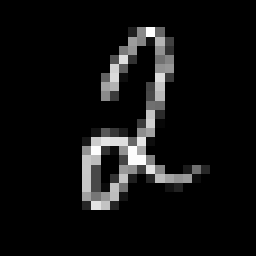

In [ ]:
show_image(train_dataset[2])

## Creating Dataloaders for each dataset

In [ ]:
from torch.utils.data import DataLoader
## TODO:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size = 256,
    num_workers = 2 
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size = 256,
    num_workers = 2 
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size = 256,
    num_workers = 2 
)


#Creaing our Model

We'll be using logistic regression, in the following block, we create our model to be used for training

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class LogisticRegression(nn.Module):
    def __init__(self,img_width,img_length,num_classes):
        super(LogisticRegression, self).__init__()                
        # in = 28*28 , out = 10
        
        self.img_length = img_length
        self.img_width = img_width
        self.linear = nn.Linear(img_width*img_length,num_classes)

    def flatten_images(self,images):
        B,C,W,H = images.shape
        flat_images = images.reshape((B,self.img_length*self.img_width))
        return flat_images

    def forward(self,images):
        # print(images.shape)
        flat_images = self.flatten_images(images)
        # print(flat_images.shape)
        output = self.linear(flat_images)
        # print(output.shape)
        log_probabilities = F.log_softmax(output,dim=1)
        # print(log_probabilities.shape)
        return log_probabilities


class MLP(nn.Module):
    def __init__(self,img_width,img_length,num_classes):
        super(MLP, self).__init__()
        self.img_length = img_length
        self.img_width = img_width
        self.linear1 = nn.Linear(img_width*img_length,256)
        self.linear2 = nn.Linear(256,64)
        self.linear3 = nn.Linear(64,num_classes)

    def flatten_images(self,images):
        B,C,W,H = images.shape
        flat_images = images.reshape((B,self.img_length*self.img_width))
        return flat_images

    def forward(self,images):
        # print(images.shape)
        flat_images = self.flatten_images(images)
        x = F.relu(self.linear1(flat_images))
        x = F.relu(self.linear2(x))
        output = self.linear3(x)

        log_probabilities = F.log_softmax(output,dim=1)
        
        return log_probabilities


In [ ]:
import torch.optim as optim


## TODO:
model = ConvNet(28,28,10).to('cuda')
learning_rate = 0.05
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(),lr=learning_rate)

# Training settings
num_epochs = 10

In [ ]:
from tqdm import tqdm

loss_epochs = []
val_epochs = []
for epoch in range(num_epochs):
    train_bar = tqdm(train_loader)
    total_loss = 0


    ## TRAINING ## 
    for batch_images,batch_labels in train_bar:
        optimizer.zero_grad()
    
        batch_images,batch_labels = batch_images.to('cuda'),batch_labels.to('cuda')
        output = model(batch_images)

        # calc loss
        loss = loss_function(output,batch_labels)

        # propagate loss
        loss.backward()

        # update the parameters
        optimizer.step()
        total_loss+= loss.item()
        train_bar.set_postfix({'loss':f'{loss.item():.2f}','epoch':epoch})
    

    ## logging training statistics
    average_loss = total_loss/len(train_loader)
    loss_epochs += [average_loss]
    print(f'Epoch {epoch} average loss: {average_loss:.2f}')
    
    ## VALIDATION ##
    with torch.no_grad():
        correct = 0
        for batch_images,batch_labels in tqdm(val_loader):
            ## TODO: 
            batch_images,batch_labels = batch_images.to('cuda'),batch_labels.to('cuda')
            output = model(batch_images)
            predictions = output.argmax(dim=1)
            correct += predictions.eq(batch_labels).sum().item()

        ## logging validation statistics
        val_accuracy = correct/len(val_loader.dataset)
        val_epochs += [val_accuracy]
        print(f'Epoch {epoch}, val acc; {val_accuracy:2f}')


In [ ]:
## Visualizing training

plot_metric(loss_epochs,"average losses")
plot_metric(val_epochs,"validation accuracy")

In [ ]:
with torch.no_grad():
    correct = 0
    ## TEST ## 
    for batch_images,batch_labels in tqdm(test_loader):
        batch_images,batch_labels = batch_images.to('cuda'),batch_labels.to('cuda')
        output = model(batch_images)
        predictions = output.argmax(dim=1)
        correct += predictions.eq(batch_labels).sum().item()
        
    print(f'epoch {epoch}, test acc; {correct/len(test_loader.dataset):.2f}')


In [ ]:
## VISUALIZE TEST SET RESULTS